In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/PP
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/PP
TensorFlow 2.x selected.


biceps = ch1
triceps = ch2
https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/hyperparameter_tuning_with_hparams.ipynb#scrollTo=KBHp6M_zgjp4

In [0]:
import warnings
warnings.filterwarnings("ignore")
import csv
import os
import urllib
import urllib.request

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal
import scipy.io as sio
from scipy.signal import freqz
from scipy.signal import butter, lfilter
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

%matplotlib inline
from sklearn.utils import shuffle
#import libraries
import scipy.io.wavfile as wav
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from skimage.util.shape import view_as_windows
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
import tensorflow as tf
import librosa
import librosa.display
from scipy import misc
import scipy
import pandas as pd
from matplotlib.pyplot import specgram
import math
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.python.keras.layers import Dense, Conv2D, Conv1D, Dropout, Flatten, MaxPooling2D, MaxPooling1D, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import utils
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tqdm import tnrange, tqdm_notebook
from time import sleep
!pip install keras_tqdm
from keras_tqdm import TQDMNotebookCallback
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


np.random.seed(1)
%matplotlib inline
plt.rc('figure', figsize=(10, 10))

Using TensorFlow backend.


# Data Collection

In [0]:
# Camera data
data_camera = [pd.DataFrame({'x' : [], 'y' : [], 'z' : []}), pd.DataFrame({'x' : [], 'y' : [], 'z' : []}), pd.DataFrame({'x' : [], 'y' : [], 'z' : []})]

for idx, data_trajectory in enumerate(data_camera):
    csv_file = pd.read_csv('./data/Camera/Trajectory_'+str(idx+1)+'.csv', sep=',', header=None, index_col = 0)
    csv_file = csv_file.astype(float)
    x = []
    y = []
    z = []
    for i in range(1, int(len(csv_file.columns)/3)+1):
        for j in range(1, len(csv_file[i])+1):
            if csv_file[i][j] != 0 and csv_file[i+1][j] != 0 and csv_file[i+2][j] != 0:
                x.append(csv_file[i][j])
                y.append(csv_file[i+1][j])
                z.append(csv_file[i+2][j])
    data_trajectory['x'] = x
    data_trajectory['y'] = y
    data_trajectory['z'] = z

In [0]:
# EMG data
pd_data = pd.read_csv("./data/EMG/6_Gestures.csv", sep=';')
pd_data = pd_data.drop(pd_data.index[[0]])
pd_data = pd_data.astype(float)
pd_data = pd_data.rename(columns={"Shimmer_CB95_Timestamp_Unix_CAL": "timestamp", "Shimmer_CB95_EMG_CH1_24BIT_CAL": "ch1", "Shimmer_CB95_EMG_CH2_24BIT_CAL": "ch2"})
pd_data = pd_data.drop(['Unnamed: 3'], axis=1)
pd_data['timestamp'] = pd_data['timestamp'] /1000 # convert to s
# correction
pd_data['ch1'][65110] = pd_data['ch1'][65111] = pd_data['ch1'][65112] = pd_data['ch1'][65109]
# recordings separation
datasplit_index = np.argwhere(np.gradient( pd_data['timestamp'].to_numpy())>1)
data_gestures = []
data_gestures.append(pd_data[37179+120:74102].reset_index(drop = True))
data_gestures[0]['timestamp'] = (data_gestures[0]['timestamp']- data_gestures[0]['timestamp'][0])
data_gestures.append(pd_data[74103+120:112556].reset_index(drop = True))
data_gestures[1]['timestamp'] = (data_gestures[1]['timestamp']- data_gestures[1]['timestamp'][0])
data_gestures.append(pd_data[112557+50:].reset_index(drop = True))
data_gestures[2]['timestamp'] = (data_gestures[2]['timestamp']- data_gestures[2]['timestamp'][0])
# plot samples in time
ax = plt.gca()
data_gestures[0].plot(kind='line',x='timestamp',y='ch1',ax=ax)
data_gestures[1].plot(kind='line',x='timestamp',y='ch1',ax=ax)
data_gestures[2].plot(kind='line',x='timestamp',y='ch1',ax=ax)
#plt.show()
plt.savefig('recordings_ch1.svg')
plt.close()
ax = plt.gca()
data_gestures[0].plot(kind='line',x='timestamp',y='ch2',ax=ax)
data_gestures[1].plot(kind='line',x='timestamp',y='ch2',ax=ax)
data_gestures[2].plot(kind='line',x='timestamp',y='ch2',ax=ax)
#plt.show()
plt.savefig('recordings_ch2.svg')
plt.close()
sampling_rate = 1 / (data_gestures[0]['timestamp'][1] - data_gestures[0]['timestamp'][0])
num_classes = 6
print("Sampling rate:", sampling_rate, "Hz")

Sampling rate: 120.04648100975987 Hz


# Data Preprocessing

## Low pass filter

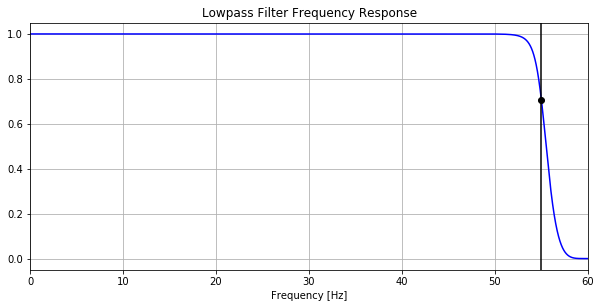

In [0]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 5
cutoff = 55  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
lp_num, lp_denum = butter_lowpass(cutoff, sampling_rate, order)

# Plot the frequency response.
w, h = freqz(lp_num, lp_denum, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*sampling_rate*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*sampling_rate)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.savefig('low_pass.svg')

## Notch filter

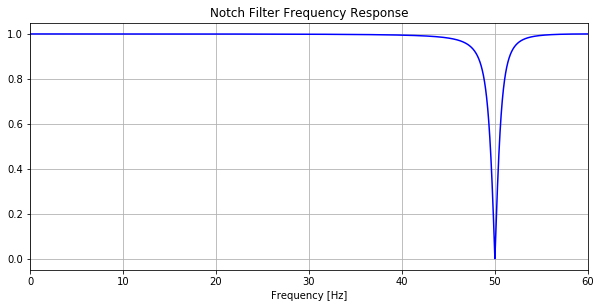

In [0]:
nf_freq = 50.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor
nf_num, nf_denum = signal.iirnotch(nf_freq, Q, sampling_rate)

# Plot the frequency response.
w, h = freqz(nf_num, nf_denum, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*sampling_rate*w/np.pi, np.abs(h), 'b')
plt.xlim(0, 0.5*sampling_rate)
plt.title("Notch Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.savefig('notch_filter.svg')

## Apply filters to the recorded signals

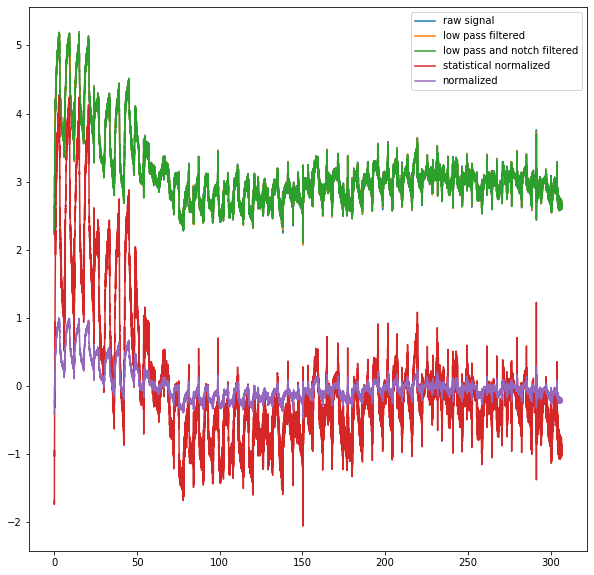

In [0]:
# apply filters
for idx, data in enumerate(data_gestures):
    data['ch1_lp'] = signal.filtfilt(lp_num, lp_denum, data['ch1'])
    data['ch2_lp'] = signal.filtfilt(lp_num, lp_denum, data['ch2'])
    data['ch1_lp_nf'] = signal.filtfilt(nf_num, nf_denum, data['ch1_lp'])
    data['ch2_lp_nf'] = signal.filtfilt(nf_num, nf_denum, data['ch2_lp'])
    data['ch1_stat_norm'] = (data['ch1_lp_nf']-data['ch1_lp_nf'].mean())/data['ch1_lp_nf'].std()
    data['ch2_stat_norm'] = (data['ch2_lp_nf']-data['ch2_lp_nf'].mean())/data['ch2_lp_nf'].std()
    scale_ch1 = np.max(np.abs(data['ch1_stat_norm']))
    scale_ch2 = np.max(np.abs(data['ch2_stat_norm']))
    data['ch1_ready'] = data['ch1_stat_norm']/scale_ch1
    data['ch2_ready'] = data['ch2_stat_norm']/scale_ch2
    
# plot an example
for set in range(1):
    plt.plot(data_gestures[set]['timestamp'], data_gestures[set]['ch1'])
    plt.plot(data_gestures[set]['timestamp'], data_gestures[set]['ch1_lp'])
    plt.plot(data_gestures[set]['timestamp'], data_gestures[set]['ch1_lp_nf'])
    plt.plot(data_gestures[set]['timestamp'], data_gestures[set]['ch1_stat_norm'])
    plt.plot(data_gestures[set]['timestamp'], data_gestures[set]['ch1_ready'])
    plt.legend(['raw signal', 'low pass filtered', 'low pass and notch filtered', 'statistical normalized', 'normalized'])
plt.savefig('processing.svg')
plt.show()

# Segmentation

In [0]:
# split to chunks function
def splitDataFrameIntoSmaller(df, chunkSize = 10000): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize].reset_index(drop = True))
    return listOfDf
def splitNpArrayIntoSmaller(array, chunkSize = 10000): 
    listOfNp = []
    numberChunks = len(array) // chunkSize
    for i in range(numberChunks):
        listOfNp.append(array[i*chunkSize:(i+1)*chunkSize])
    return np.array(listOfNp)

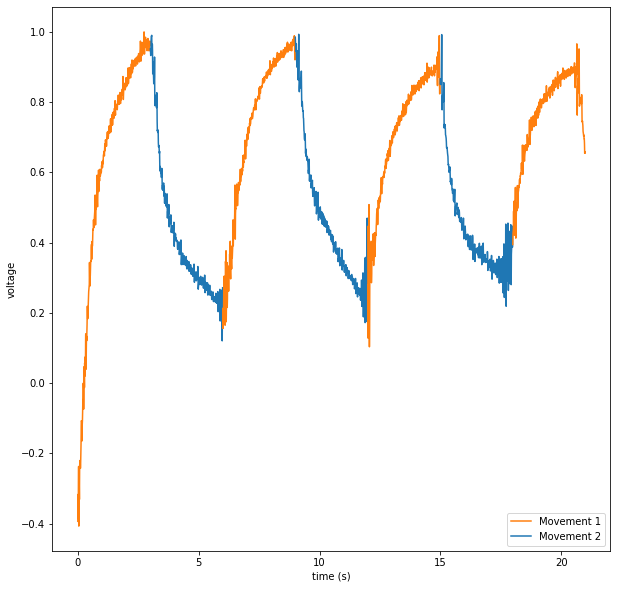

103 107 111


In [0]:
# split emg signals
no_samples = 360 #no of samples in a segment
data_gestures_chunks = [None, None, None]
for idx, data in enumerate(data_gestures):
    data_gestures_chunks[idx] = splitDataFrameIntoSmaller(data, chunkSize = no_samples)
    
    
# plot splited emg signals
for set in range(1):
    for i in range (0,7):
        if i % 2 == 0:
            color = 'tab:orange'
        else:
            color = 'tab:blue'
        plt.plot(data_gestures_chunks[set][i]['timestamp'], data_gestures_chunks[set][i]['ch1_ready'], color=color)
        #plt.plot(data_gestures_chunks[set][i]['timestamp'], data_gestures_chunks[set][i]['ch2_ready'])
    plt.xlabel("time (s)")
    plt.ylabel("voltage")
    plt.legend(["Movement 1", "Movement 2"])
    plt.savefig("labeled.svg")
    plt.show()
print(len(data_gestures_chunks[0]), len(data_gestures_chunks[1]), len(data_gestures_chunks[2]))

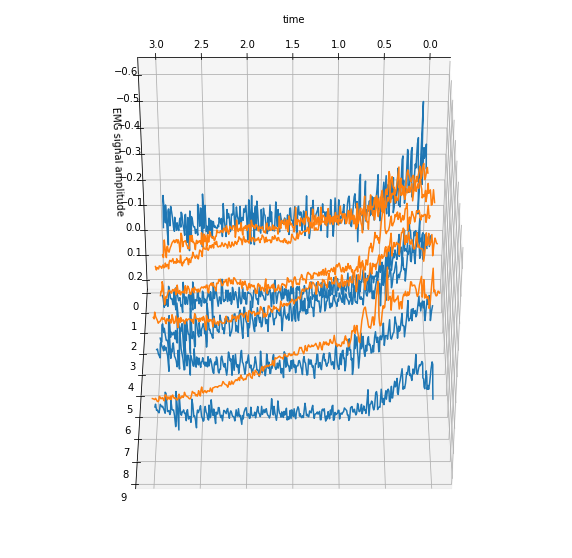

In [0]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for idx, i in enumerate(list(range (10))):
    if idx % 2 == 0:
        plt.plot(data_gestures_chunks[1][0]['timestamp'], data_gestures_chunks[1][i]['ch1_ready'], idx, color='tab:blue') # class 3
        
    if idx % 2 == 1:
        plt.plot(data_gestures_chunks[2][0]['timestamp'], data_gestures_chunks[2][i]['ch1_ready'], idx, color='tab:orange') # class 5
ax.view_init(130, 90)
plt.xlabel("time")
plt.ylabel("EMG signal amplitude")
plt.savefig("3d.svg")

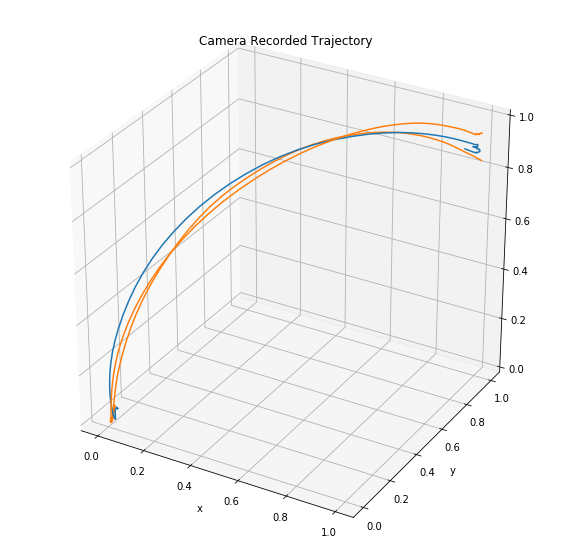

In [0]:
# split 3d camera signals
no_samples = 400 #no of samples in a segment
data_camera_chunks = [None, None, None]
for idx, data in enumerate(data_camera):
    data_camera_chunks[idx] = splitDataFrameIntoSmaller(data, chunkSize = no_samples)
    for data in data_camera_chunks[idx]:
        data['x_stat_norm'] = (data['x']-data['x'].mean())/data['x'].std()
        data['y_stat_norm'] = (data['y']-data['y'].mean())/data['y'].std()
        data['z_stat_norm'] = (data['z']-data['z'].mean())/data['z'].std()
        data['x_ready'] = (data['x_stat_norm']-data['x_stat_norm'].min())/(data['x_stat_norm'].max()-data['x_stat_norm'].min())
        data['y_ready'] = (data['y_stat_norm']-data['y_stat_norm'].min())/(data['y_stat_norm'].max()-data['y_stat_norm'].min())
        data['z_ready'] = (data['z_stat_norm']-data['z_stat_norm'].min())/(data['z_stat_norm'].max()-data['z_stat_norm'].min())
# plot splited 3d trajectories signals
ax = plt.axes(projection='3d')
set = 0
for i in range (0,3):
    if i % 2 == 0:
        color = 'tab:orange'
    else:
        color = 'tab:blue'
    ax.plot3D(data_camera_chunks[set][i]['x_ready'], data_camera_chunks[set][i]['y_ready'], data_camera_chunks[set][i]['z_ready'], color=color)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Camera Recorded Trajectory")
plt.savefig("labeled_cam.svg")
plt.show()

In [0]:
# regroup sequences and label them 
data_samples = []
data_labels = []
sample_length = None
for gestures_id, data_gestures_chunk in enumerate(data_gestures_chunks):
    for sequence_id, sequence in enumerate(data_gestures_chunk):
        if not sample_length:
            sample_length = sequence['ch1_ready'].shape
        if sequence['ch1_ready'].shape != sample_length or sequence['ch2_ready'].shape != sample_length:
            continue
        data_samples.append(sequence['ch1_ready'])
        data_samples.append(sequence['ch2_ready'])
        label = gestures_id*2+(sequence_id % 2)
        data_labels.append(label)
        data_labels.append(label)
data_samples = np.array(data_samples)
data_labels = np.array(data_labels)
print(data_samples.shape)

(636, 360)


In [0]:
# segmentation to 200ms
data_segments = []
data_segments_labels = []
for id, data in enumerate(data_samples):
        data_chunks = splitNpArrayIntoSmaller(data, chunkSize = 72) #200ms segments
        data_segments.append(data_chunks)
        data_segments_labels.append([data_labels[id],]*data_chunks.shape[0])
data_segments = np.array(data_segments)
data_segments_labels = np.array(data_segments_labels)
data_segments = data_segments.reshape(-1, data_segments.shape[-1])
data_segments_labels = data_segments_labels.reshape(-1)
print(np.array(data_segments).shape)

(3180, 72)


# Features Extraction

## Time Domain

In [0]:
data_td_features = []
for id, data in enumerate(data_samples):
    data_chunks = splitNpArrayIntoSmaller(data, chunkSize = 50) # 200 ms
    data_chunk_td_features = []
    for data_sample in data_chunks:
        data_sample = np.array(data_sample)
        mav = data_sample.mean() # Mean Absolute Value
        rms = np.sqrt(np.mean(np.square(data_sample))) # Root Mean Square
        var = np.var(data_sample) # Variance
        ssc = len(np.where(np.diff(np.sign(data_sample)))[0]) # Slope sign change
        max_amp = np.max(data_sample)
        min_amp = np.min(data_sample)
        data_chunk_td_features.append(mav)
        data_chunk_td_features.append(rms)
        data_chunk_td_features.append(var)
        data_chunk_td_features.append(ssc)
        data_chunk_td_features.append(max_amp)
        data_chunk_td_features.append(min_amp)
    data_td_features.append(data_chunk_td_features)
data_td_features = np.array(data_td_features)
print(data_td_features.shape)

(636, 42)


## Time and Frequency Domain (Spectrogram)

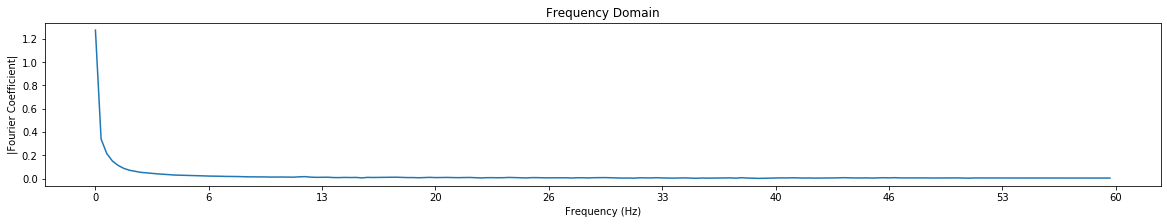

In [0]:
def get_xn(Xs,n):
    '''
    calculate the Fourier coefficient X_n of 
    Discrete Fourier Transform (DFT)
    '''
    L  = len(Xs)
    ks = np.arange(0,L,1)
    xn = np.sum(Xs*np.exp((1j*2*np.pi*ks*n)/L))/L
    return(xn)

def get_xns(ts):
    '''
    Compute Fourier coefficients only up to the Nyquest Limit Xn, n=1,...,L/2
    and multiply the absolute value of the Fourier coefficients by 2, 
    to account for the symetry of the Fourier coefficients above the Nyquest Limit. 
    '''
    mag = []
    L = len(ts)
    for n in range(int(L/2)): # Nyquest Limit
        mag.append(np.abs(get_xn(ts,n))*2)
    return(mag)

def get_Hz_scale_vec(ks,sample_rate,Npoints):
    freq_Hz = ks*sample_rate/Npoints
    freq_Hz  = [int(i) for i in freq_Hz ] 
    return(freq_Hz )

ts = data_samples[0]
mag = get_xns(ts)

Nxlim = 10
ks   = np.linspace(0,len(mag),Nxlim)
ksHz = get_Hz_scale_vec(ks,sampling_rate,len(ts))

plt.figure(figsize=(20,3))
plt.plot(mag)
plt.xticks(ks,ksHz)
plt.title("Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|Fourier Coefficient|")
plt.show()

In [0]:
def create_spectrogram(ts,NFFT,noverlap):
    '''
          ts: original time series
        NFFT: The number of data points used in each block for the DFT.
          Fs: the number of points sampled per second, so called sample_rate
    noverlap: The number of points of overlap between blocks. The default value is 128. 
    '''
    noverlap = int(noverlap)
    starts  = np.arange(0,len(ts),NFFT-noverlap,dtype=int)
    # remove any window with less than NFFT sample size
    starts  = starts[starts + NFFT <= len(ts)]
    
    xns = []
    
    for start in starts:
        # short term discrete fourier transform
        ts_window = get_xns(ts[start:start + NFFT])
        xns.append(ts_window)
    specX = np.array(xns).T
    # rescale the absolute value of the spectrogram as rescaling is standard
    #spec = 10*np.log10(specX)
    #assert spec.shape[1] == len(starts) 
    return(specX)

In [0]:
def plot_spectrogram(spec,ks,sample_rate, L, starts, mappable = None):
    plt.figure(figsize=(20,8))
    plt_spec = plt.imshow(spec,origin='lower')

    ## create ylim
    Nyticks = 10
    ks      = np.linspace(0,spec.shape[0],Nyticks)
    ksHz    = get_Hz_scale_vec(ks,sample_rate,len(ts))
    plt.yticks(ks,ksHz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    #Nxticks = 10
    #ts_spec = np.linspace(0,spec.shape[1],Nxticks)
    #ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0,total_ts_sec*starts[-1]/len(ts),Nxticks)]
    #plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title("Spectrogram L={} Spectrogram.shape={}".format(L,spec.shape))
    plt.colorbar(mappable,use_gridspec=True)
    plt.show()
    return(plt_spec)

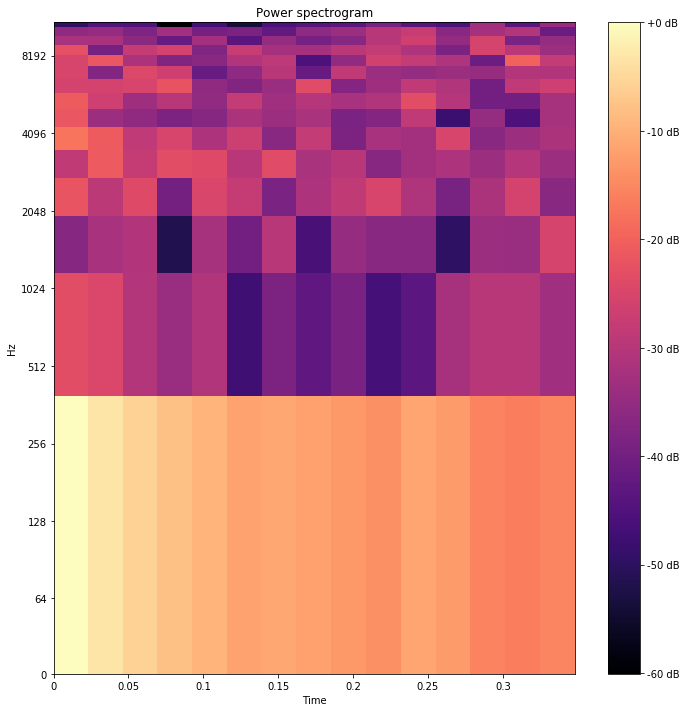

In [0]:
L = 30
noverlap = 7

generate_specs = True
if generate_specs :
    spectrograms = []
    spectrogram_dims = None
    for sequence in data_samples:
        spec = create_spectrogram(sequence,L,noverlap)
        spectrograms.append(spec) #librosa.core.stft(ts.to_numpy(), n_fft=54)#
spectrograms = np.array(spectrograms)
#spectrograms = np.expand_dims(spectrograms, -1)
idd2 = [i for i, x in enumerate(data_labels) if x== 4]
idd5 = [i for i, x in enumerate(data_labels) if x== 2]
librosa.display.specshow(librosa.amplitude_to_db(spectrograms[idd2[0]], ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.savefig("spec_3.svg")
librosa.display.specshow(librosa.amplitude_to_db(spectrograms[idd5[0]], ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
#plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.savefig("spec_4.svg")

# Classification

## Split Data

In [0]:
def split_data(data_samples, data_labels, num_classes, normalize_01 = False):
    num_classes = 6
    # the data, split between train and test sets
    x_train, x_test, y_train, y_test = train_test_split(data_samples, data_labels, test_size=0.2, random_state=42)
    if normalize_01:
        x_train /= np.max(np.abs(x_train))
        x_test /= np.max(np.abs(x_test))
    y_train = utils.to_categorical(y_train, num_classes)
    y_test = utils.to_categorical(y_test, num_classes)
    return x_train, x_test, y_train, y_test
def import_data(type_data, type_network):
    if type_data == 'spectrograms':
        if type_network == 'CNN' or type_network == 'LSTM':
            specs = spectrograms
        else:
            specs = spectrograms.reshape(-1, spectrograms.shape[1]*spectrograms.shape[2])
        return split_data(specs, data_labels, num_classes, normalize_01 = True)
    if type_data == 'segments':
        return split_data(data_segments, data_segments_labels, num_classes)
    if type_data == 'full':
        return split_data(data_samples, data_labels, num_classes)
    if type_data == 'td_features':
        return split_data(data_td_features, data_labels, num_classes)

data_types = ['full', 'segments', 'spectrograms']

## Define, Train and Evaluate Models

### SVM

In [0]:
def train_test_svm(x_train, x_test, y_train, y_test, kernel, verbose, save, file_name):
    def make_meshgrid(x, y, h=.02):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return xx, yy

    def plot_contours(ax, clf, xx, yy, **params):
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
        return out

    # PCA + SVM pipeline
    pca = PCA(n_components=2)
    Xreduced = pca.fit_transform(x_train)
    model = SVC(kernel=kernel)
    clf = model.fit(Xreduced, y_train)

    y_pred = model.predict(pca.fit_transform(x_test))
    accuracy = accuracy_score(y_test, y_pred)

    # Plot confusion matrix
    fig = plt.figure()
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=[i for i in range(6)],
                yticklabels=[i for i in range(6)])
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    if verbose:
        plt.show()
    if save:
        plt.savefig("./results/SVM/svm_"+file_name+"_confusion.svg")
    plt.close(fig)
        

    # Plot SVM decision surfaces
    fig = plt.figure()
    title = ('Decision surface of RBF SVM ')
    X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    ax = plt.axes()
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plt.ylabel('PC2')
    plt.xlabel('PC1')
    plt.title('Decison surface using the PCA transformed/projected features')
    if verbose:
        plt.show()
    if save:
        plt.savefig("./results/SVM/svm_"+file_name+"_boundries.svg")
    plt.close(fig)
    return accuracy, y_pred

def fine_tune_svm(x_train, x_test, y_train, y_test, hp_kernels, verbose = 0, save = False, file_name =''):
    if not verbose:
        plt.ioff()
    # Plot the PCA spectrum
    pca = PCA()
    pca.fit(x_train)
    fig = plt.figure()
    plt.plot(np.arange(1, pca.n_components_ + 1),
            pca.explained_variance_ratio_, '+', linewidth=2)
    plt.xlabel('Eigenmode')
    plt.ylabel('PCA explained variance ratio')
    if verbose:
        plt.show()
    if save:
        plt.savefig("./results/SVM/svm_"+file_name+"_explained_variance_ratio.svg")
    plt.ioff()
    plt.close(fig)
    hp = [kernel for kernel in hp_kernels]
    best_accuracies = []
    best_accuracy = 0
    pbar = tqdm_notebook(total=len(hp))
    row_list = [["id", "kernel", "best_acc", "acc_1"]]
    for idx, (kernel) in enumerate(hp):
        param = 'kernel: ' +str(kernel)
        accuracy, preds = train_test_svm(x_train, x_test, y_train, y_test,
                    kernel = kernel, verbose = verbose, save = save, file_name = file_name+"_"+str(idx))
        row_list.append([idx, kernel, accuracy, accuracy])
        pbar.update(1)
        if verbose:
            print(param, accuracy)
        best_accuracies.append(accuracy)
        if best_accuracies[idx] > best_accuracy:
            best_accuracy = best_accuracies[idx]
            best_hist = preds
            best_idx = idx
            best_param = param
    pbar.update(1)
    fig = plt.figure()
    for idx, acc in enumerate(best_accuracies) :
        plt.scatter(idx, acc)
    plt.ylabel('Accuracy')
    plt.xlabel('Model number')
    plt.title('Accuracies of the evaluated models')
    if verbose:
        plt.show()
    if save:
        plt.savefig("./results/SVM/svm_"+file_name+"_best_accuracies.svg")
    plt.close(fig)

    np.savetxt('./results/SVM/svm_predictions_'+file_name+'.csv', [y_test, best_hist], delimiter=",", fmt='%d')

    if save:
        with open('./results/SVM/svm_'+file_name+'.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(row_list)

    print("Best model no", best_idx, "achieved accuracy of", str(best_accuracy*100)+"%", "with parameters", best_param)

In [0]:
# hyperparameters
hp_kernels = ['linear', 'rbf', 'poly', 'sigmoid']

In [0]:
for data_type in data_types + ['td_features']:
    x_train, x_test, y_train, y_test = import_data(data_type, 'SVM')
    fine_tune_svm(x_train, x_test, y_train.argmax(-1), y_test.argmax(-1), hp_kernels, verbose = 0, save = True, file_name=data_type)

### MLP

In [0]:
def train_test_mlp(x_train, x_test, y_train, y_test, num_units, dropout, optimizer, batch_size, epochs, verbose):
    tf.keras.backend.clear_session()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    #Define Model
    model = Sequential()
    for no, nbr in enumerate(num_units):
        if no == 0:
            model.add(Dense(nbr, activation='relu', input_shape=(x_train.shape[1],)))
        else:
            model.add(Dense(nbr, activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    #Compile
    if verbose:
        callbacks = [TQDMNotebookCallback()]
    else:
        callbacks = []
    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=verbose,
                        callbacks=callbacks,
                        validation_data=(x_test, y_test))
    return history, model

def fine_tune_mlp(x_train, x_test, y_train, y_test, hp_num_units, hp_dropout, hp_optimizer_lr, hp_batch_size, epochs = 200, verbose = 0, save = False, file_name=''):
    if not verbose:
        plt.ioff()
    hp = [[num_units, dropout, optimizer_lr, batch_size] for num_units in hp_num_units for dropout in hp_dropout for optimizer_lr in hp_optimizer_lr for batch_size in hp_batch_size]
    best_accuracies = []
    best_accuracy = 0
    pbar = tqdm_notebook(total=len(hp))
    row_list = [["id", "num_units", "dropout", "optimizer_lr", "batch_size", "best_acc"]+["acc_"+str(i+1) for i in range(epochs)]]
    for idx, (num_units, dropout, optimizer_lr, batch_size) in enumerate(hp):
        param = 'num_units: ' +str(num_units) + ' - dropout: ' + str(dropout) + ' - optimizer_lr: ' + str(optimizer_lr)+ ' - batch_size: '+ str(batch_size)
        hist, model = train_test_mlp(x_train, x_test, y_train, y_test,
                    num_units = num_units, dropout = dropout,
                    optimizer = Adam(learning_rate = optimizer_lr), batch_size = batch_size, epochs = epochs,
                    verbose = 0)
        best_accuracies.append(np.max(hist.history['val_acc']))
        if best_accuracies[idx] > best_accuracy:
            best_accuracy = best_accuracies[idx]
            best_hist = hist
            best_model = model
            best_idx = idx
            best_param = param
        pbar.update(1)
        row_list.append([idx, num_units, dropout, optimizer_lr, batch_size, np.max(hist.history['val_acc'])]+ hist.history['val_acc'])
    
    fig = plt.figure()
    for idx, acc in enumerate(best_accuracies) :
        plt.scatter(idx, acc)
    plt.ylabel('Accuracy')
    plt.xlabel('Model number')
    plt.title('Accuracies of the evaluated models')
    if verbose:
        plt.show()
    if save:
        plt.savefig("./results/MLP/mlp_"+file_name+"_best_accuracies.svg")
    plt.close(fig)
    
    fig = plt.figure()
    plt.plot(best_hist.history['acc'])
    plt.plot(best_hist.history['val_acc'])
    plt.title('Best model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    if verbose:
        plt.show()
    if save:
        plt.savefig("./results/MLP/mlp_"+file_name+"_best_model_accuracy.svg")
    plt.close(fig)

    fig = plt.figure()
    plt.plot(best_hist.history['loss'])
    plt.plot(best_hist.history['val_loss'])
    plt.title('Best model categorical crossentropy loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    if verbose:
        plt.show()
    if save:
        plt.savefig("./results/MLP/mlp_"+file_name+"_best_model_loss.svg")
    plt.close(fig)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    predictions = best_model.predict(x_test)
    np.savetxt('./results/MLP/mlp_predictions_'+file_name+'.csv', [y_test.argmax(axis=-1), predictions.argmax(axis=-1)], delimiter=",", fmt='%d')
    
    if save:
        with open('./results/MLP/mlp_'+file_name+'.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(row_list)

    print("Best model no", best_idx, "achieved accuracy of", str(best_accuracy*100)+"%", "with parameters", best_param)

In [0]:
# hyperparameters
hp_num_units = [[64], [128], [256], [64, 32], [64, 32, 16]]
hp_dropout = [0.2, 0.5]
hp_optimizer = [0.001]
hp_batch_size = [32, 64, 128]

In [0]:
for data_type in data_types + ['td_features']:
    x_train, x_test, y_train, y_test = import_data(data_type, 'MLP')
    fine_tune_mlp(x_train, x_test, y_train, y_test, hp_num_units, hp_dropout, hp_optimizer, hp_batch_size,
                epochs = 200, verbose = 0, save = True, file_name = data_type)

Best model no 15 achieved accuracy of 66.40625% with parameters num_units: [256] - dropout: 0.5 - optimizer_lr: 0.001 - batch_size: 32


Best model no 25 achieved accuracy of 36.32075488567352% with parameters num_units: [64, 32, 16] - dropout: 0.2 - optimizer_lr: 0.001 - batch_size: 64


Best model no 18 achieved accuracy of 81.25% with parameters num_units: [64, 32] - dropout: 0.2 - optimizer_lr: 0.001 - batch_size: 32


Best model no 18 achieved accuracy of 61.71875% with parameters num_units: [64, 32] - dropout: 0.2 - optimizer_lr: 0.001 - batch_size: 32


### CNN

In [0]:
def train_test_cnn(x_train, x_test, y_train, y_test, num_units_conv, kernel_sizes, pool_sizes, num_units_fc, dropout, optimizer, batch_size, epochs, verbose):
    tf.keras.backend.clear_session()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    if len(x_train.shape) > 2: # 2d case
        Conv = Conv2D
        MaxPooling = MaxPooling2D
        if len(x_train.shape) < 4:
            x_train = np.expand_dims(x_train, -1)
        if len(x_test.shape) < 4:
            x_test = np.expand_dims(x_test, -1)
    else:
        Conv = Conv1D
        MaxPooling = MaxPooling1D
        if len(x_train.shape) < 3:
            x_train = np.expand_dims(x_train, -1)
        if len(x_test.shape) < 3:
            x_test = np.expand_dims(x_test, -1)
    #Define Model
    model = Sequential()
    for no, nbr in enumerate(num_units_conv):
        if no == 0:
             model.add(Conv(nbr, kernel_size=(kernel_sizes), activation='relu', input_shape=x_train[0].shape))
        else:
            model.add(Conv(nbr, kernel_size=(kernel_sizes), activation='relu'))
            model.add(MaxPooling(pool_size=(pool_sizes)))
    model.add(Flatten())
    for no, nbr in enumerate(num_units_fc):
        model.add(Dense(nbr, activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(y_train.shape[-1], activation='softmax'))
    #Compile
    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])
    if verbose:
        callbacks = [TQDMNotebookCallback()]
    else:
        callbacks = []
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=verbose,
                        callbacks=callbacks,
                        validation_data=(x_test, y_test))
    return history, model

def fine_tune_cnn(x_train, x_test, y_train, y_test, hp_num_units_conv, hp_kernel_sizes, hp_pool_sizes, hp_num_units_fc, hp_dropout, hp_optimizer_lr, hp_batch_size, epochs = 200, verbose = 0, save = False, file_name = ''):
    hp = [[num_units_conv, kernel_sizes, pool_sizes, num_units_fc, dropout, optimizer_lr, batch_size] for num_units_conv in hp_num_units_conv for kernel_sizes in hp_kernel_sizes for pool_sizes in hp_pool_sizes for num_units_fc in hp_num_units_fc for dropout in hp_dropout for optimizer_lr in hp_optimizer_lr for batch_size in hp_batch_size]
    best_accuracies = []
    best_accuracy = 0
    pbar = tqdm_notebook(total=len(hp))
    row_list = [["id", "num_units_conv", "kernel_sizes", "pool_sizes", "num_units_fc", "dropout", "optimizer_lr", "batch_size", "best_acc"]+["acc_"+str(i+1) for i in range(epochs)]]
    for idx, (num_units_conv, kernel_sizes, pool_sizes, num_units_fc, dropout, optimizer_lr, batch_size) in enumerate(hp):
        param = 'num_units_conv: ' +str(num_units_conv) + ' - kernel_sizes: ' + str(kernel_sizes) + ' - pool_sizes: ' + str(pool_sizes)+ ' - num_units_fc: '+ str(num_units_fc)+ ' - dropout: '+ str(dropout)+ ' - optimizer_lr: '+ str(optimizer_lr) + ' - batch_size:' + str(batch_size)
        hist, model = train_test_cnn(x_train, x_test, y_train, y_test,
                    num_units_conv = num_units_conv, kernel_sizes = kernel_sizes,
                    pool_sizes = pool_sizes, num_units_fc = num_units_fc, dropout = dropout,
                    optimizer = Adam(optimizer_lr), batch_size = batch_size, epochs = epochs,
                    verbose = 0)
        
        #print(param, np.max(hist.history['val_acc']))
        best_accuracies.append(np.max(hist.history['val_acc']))
        if best_accuracies[idx] > best_accuracy:
            best_accuracy = best_accuracies[idx]
            best_hist = hist
            best_model = model
            best_idx = idx
            best_param = param
        pbar.update(1)
        row_list.append([idx, num_units_conv, kernel_sizes, pool_sizes, num_units_fc, dropout, optimizer_lr, batch_size, np.max(hist.history['val_acc'])]+ hist.history['val_acc'])

    fig = plt.figure()
    for idx, acc in enumerate(best_accuracies) :
        plt.scatter(idx, acc)
    plt.ylabel('Accuracy')
    plt.xlabel('Model number')
    plt.title('Accuracies of the evaluated models')
    if verbose:
        plt.show()
    if save:
        plt.savefig("./results/CNN/cnn_"+file_name+"_best_accuracies.svg")
    plt.close(fig)
    
    fig = plt.figure()
    plt.plot(best_hist.history['acc'])
    plt.plot(best_hist.history['val_acc'])
    plt.title('Best model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    if verbose:
        plt.show()
    if save:
        plt.savefig("./results/CNN/cnn_"+file_name+"_best_model_accuracy.svg")
    plt.close(fig)

    fig = plt.figure()
    plt.plot(best_hist.history['loss'])
    plt.plot(best_hist.history['val_loss'])
    plt.title('Best model categorical crossentropy loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    if verbose:
        plt.show()
    if save:
        plt.savefig("./results/CNN/cnn_"+file_name+"_best_model_loss.svg")
    plt.close(fig)
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    if len(x_train.shape) > 2: # 2d case
        if len(x_test.shape) < 4:
            x_test = np.expand_dims(x_test, -1)
    else:
        if len(x_test.shape) < 3:
            x_test = np.expand_dims(x_test, -1)
    predictions = best_model.predict(x_test)
    np.savetxt('./results/CNN/cnn_predictions_'+file_name+'.csv', [y_test.argmax(axis=-1), predictions.argmax(axis=-1)], delimiter=",", fmt='%d')

    if save:
        with open('./results/CNN/cnn_'+file_name+'.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(row_list)

    print("Best model no", best_idx, "achieved accuracy of", str(best_accuracy*100)+"%", "with parameters", best_param)

In [0]:
# hyperparameters
hp_num_units_conv = [[64], [64, 32, 16]]
hp_kernel_sizes = [3]
hp_pool_sizes = [2]
hp_num_units_fc = [[64], [512]]
hp_dropout = [0.2, 0.5]
hp_optimizer = [0.001]
hp_batch_size = [32, 64, 128]

In [0]:
for data_type in data_types:
    x_train, x_test, y_train, y_test = import_data(data_type, 'CNN')
    fine_tune_cnn(x_train, x_test, y_train, y_test, hp_num_units_conv, hp_kernel_sizes, hp_pool_sizes, hp_num_units_fc, hp_dropout, hp_optimizer, hp_batch_size,
                epochs = 200, verbose=0, save = True, file_name=data_type)

Best model no 17 achieved accuracy of 84.375% with parameters num_units_conv: [64, 32, 16] - kernel_sizes: 3 - pool_sizes: 2 - num_units_fc: [64] - dropout: 0.5 - optimizer_lr: 0.001 - batch_size:128


### LSTM

In [0]:
def train_test_lstm(x_train, x_test, y_train, y_test, num_units, dropout, num_units_fc, optimizer, batch_size, epochs, verbose):
    tf.keras.backend.clear_session()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    if len(x_train.shape) > 2: # 2d case
        pass
    else: # 1d case
        if len(x_train.shape) < 3:
            x_train = np.expand_dims(x_train, -1)
        if len(x_test.shape) < 3:
            x_test = np.expand_dims(x_test, -1)
    #Define Model
    model = Sequential()
    model.add(LSTM(num_units, activation='relu', input_shape=x_train[0].shape, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(num_units, activation='relu'))
    model.add(Dropout(dropout))
    for no, nbr in enumerate(num_units_fc):
        model.add(Dense(nbr, activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(y_train.shape[-1], activation='softmax'))
    #Compile
    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])
    if verbose:
        callbacks = [TQDMNotebookCallback()]
    else:
        callbacks = []
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        callbacks=callbacks,
                        validation_data=(x_test, y_test))
    return history, model

def fine_tune_lstm(x_train, x_test, y_train, y_test, hp_num_units, hp_dropout, hp_num_units_fc, hp_optimizer_lr, hp_batch_size, epochs = 200, verbose = 0, save= False, file_name = ''):
    hp = [[num_units, dropout, num_units_fc, optimizer_lr, batch_size] for num_units in hp_num_units for dropout in hp_dropout for num_units_fc in hp_num_units_fc for optimizer_lr in hp_optimizer_lr for batch_size in hp_batch_size]
    best_accuracies = []
    best_accuracy = 0
    pbar = tqdm_notebook(total=len(hp))
    row_list = [["id", "num_units", "dropout", "num_units_fc", "optimizer_lr", "batch_size", "best_acc"]+["acc_"+str(i+1) for i in range(epochs)]]
    for idx, (num_units, dropout, num_units_fc, optimizer_lr, batch_size) in enumerate(hp):
        param = 'num_units: ' +str(num_units) + ' - dropout: '+ str(dropout)+  ' - num_units_fc: '+ str(num_units_fc)+ ' - optimizer_lr: '+ str(optimizer_lr) + ' - batch_size:' + str(batch_size)
        hist, model = train_test_lstm(x_train, x_test, y_train, y_test,
                    num_units = num_units, dropout = dropout, num_units_fc = num_units_fc,
                    optimizer = Adam(optimizer_lr), batch_size = batch_size, epochs = epochs,
                    verbose = verbose)
        
        print(param, np.max(hist.history['val_acc']))
        best_accuracies.append(np.max(hist.history['val_acc']))
        if best_accuracies[idx] > best_accuracy:
            best_accuracy = best_accuracies[idx]
            best_hist = hist
            best_model = model
            best_idx = idx
            best_param = param
        pbar.update(1)
        row_list.append([idx, num_units, dropout, num_units_fc, optimizer_lr, batch_size, np.max(hist.history['val_acc'])]+ hist.history['val_acc'])

    fig = plt.figure()
    for idx, acc in enumerate(best_accuracies) :
        plt.scatter(idx, acc)
    plt.ylabel('Accuracy')
    plt.xlabel('Model number')
    plt.title('Accuracies of the evaluated models')
    if verbose:
        plt.show()
    if save:
        plt.savefig("./results/LSTM/lstm_"+file_name+"_best_accuracies.svg")
    plt.close(fig)
    
    fig = plt.figure()
    plt.plot(best_hist.history['acc'])
    plt.plot(best_hist.history['val_acc'])
    plt.title('Best model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    if verbose:
        plt.show()
    if save:
        plt.savefig("./results/LSTM/lstm_"+file_name+"_best_model_accuracy.svg")
    plt.close(fig)

    fig = plt.figure()
    plt.plot(best_hist.history['loss'])
    plt.plot(best_hist.history['val_loss'])
    plt.title('Best model categorical crossentropy loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    if verbose:
        plt.show()
    if save:
        plt.savefig("./results/LSTM/lstm_"+file_name+"_best_model_loss.svg")
    plt.close(fig)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    if len(x_test.shape) < 3:
        x_test = np.expand_dims(x_test, -1)

    predictions = best_model.predict(x_test)
    np.savetxt('./results/LSTM/lstm_predictions_'+file_name+'.csv', [y_test.argmax(axis=-1), predictions.argmax(axis=-1)], delimiter=",", fmt='%d')
    
    if save:
        with open('./results/LSTM/lstm_'+file_name+'.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(row_list)
    
    print("Best model no", best_idx, "achieved accuracy of", str(best_accuracy*100)+"%", "with parameters", best_param)

In [0]:
# hyperparameters
hp_num_units = [32, 64, 128]
hp_dropout = [0.2, 0.5]
hp_num_units_fc = [[64]]
hp_optimizer = [0.001]
hp_batch_size = [32, 64, 128]

In [0]:
for data_type in data_types:
    x_train, x_test, y_train, y_test = import_data(data_type, 'LSTM')
    x_train = np.array([x.transpose() for x in x_train])
    x_test = np.array([x.transpose() for x in x_test])
    fine_tune_lstm(x_train, x_test, y_train, y_test, hp_num_units, hp_dropout, hp_num_units_fc, hp_optimizer, hp_batch_size,
                epochs = 600, verbose=1, save = True, file_name=data_type+'_bestselected')